#### The purpose of this notebooks is to test whether the single trial beta maps produce a similar maps as the SPM univariate analysis

Method:
* 1) convert .nii to .npy : scripts/step10_nilearn/glm/cue-high_GT_cue-low/glm_numpify_ttest.py
* 2) average .npy per subject (session and run concatenated): scripts/step10_nilearn/glm/cue-high_GT_cue-low/numpy_ttest_cue.py
* 3) plot the end product here.

In [5]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img
from nilearn import image
from nilearn import plotting
import argparse
from nilearn.image import new_img_like
import matplotlib.pyplot as plt


In [6]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_event-stimulus_stimintensity-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_event-stimulus_stimintensity-high.npy"))

In [8]:
suballLv.shape

(109, 458294)

In [9]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [10]:
x,y,z=ref_img.shape
H = []
L = []
for index in range(suballLv.shape[0]):
    # apply masker onto numpy array (shape of #subjects x voxels)
        
    H.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )
    


In [130]:
# x,y,z=ref_img.shape
# fmri_masked_stimhigh = nifti_masker.fit_transform(
#     new_img_like(ref_img, suballHv.reshape(x,y,z, suballHv.shape[0], ))
    
#     )
# fmri_masked_stimlow = nifti_masker.fit_transform(new_img_like(ref_img, suballLv.reshape(x,y,z, suballHv.shape[0])))

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 1.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


In [11]:
fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(109, 98053)


In [12]:
(fmri_masked_stimhigh - fmri_masked_stimlow).shape

(109, 98053)

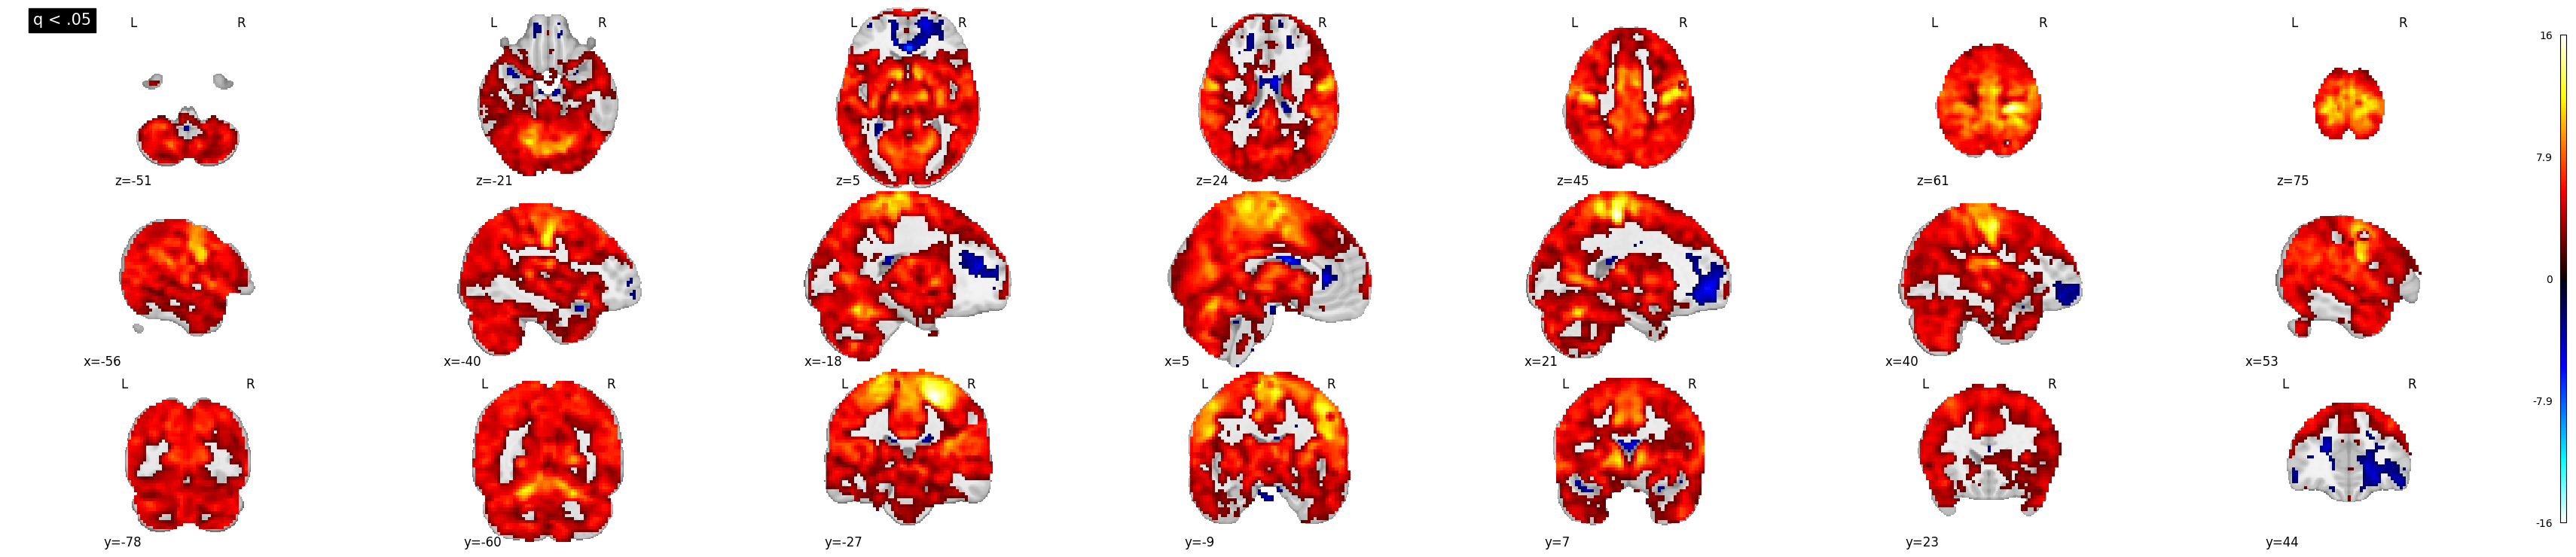

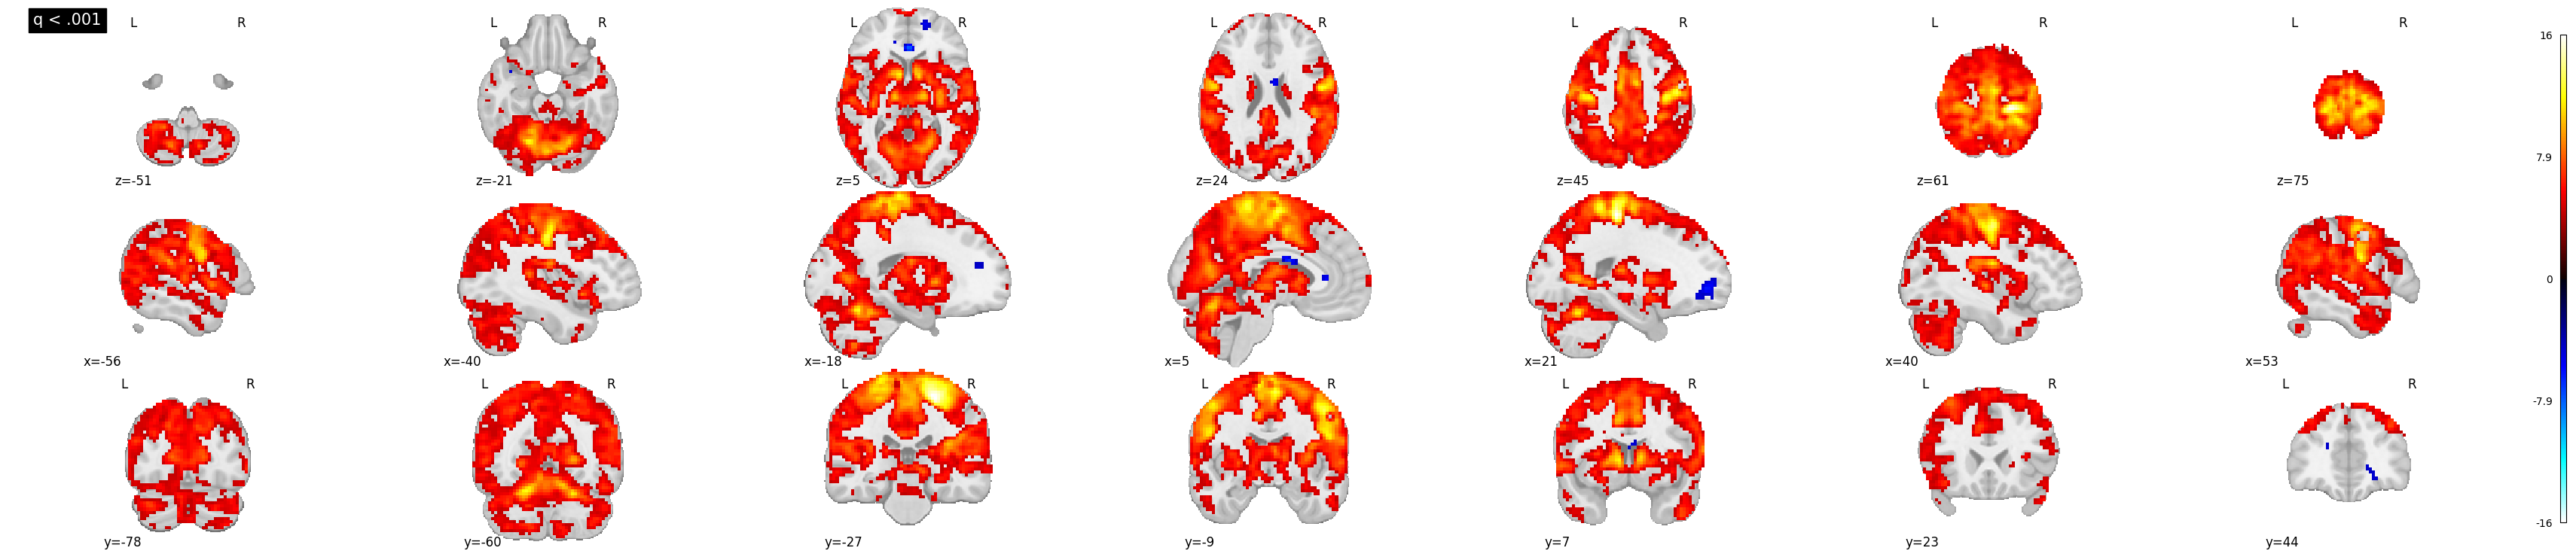

In [13]:
tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_map = np.zeros(fmri_masked_stimhigh.shape[1])
result_map[qvalues < .05] = tvalues[qvalues < .05]
con_tmap = nifti_masker.inverse_transform(result_map)

result_map_001 = np.zeros(fmri_masked_stimhigh.shape[1])
result_map_001[qvalues < .0001] = tvalues[qvalues < .0001]
con_tmap_001 = nifti_masker.inverse_transform(result_map_001)

plotting.plot_stat_map(con_tmap,  display_mode = 'mosaic', title = 'q < .05')
plotting.plot_stat_map(con_tmap_001,  display_mode = 'mosaic', title = 'q < .001')
# plotting.plot_stat_map(con_bmap, threshold = 1, display_mode = 'mosaic')

In [14]:
print(f"min: {np.min(con_tmap.get_fdata())}")
print(f"max: {np.max(con_tmap.get_fdata())}")
print(f"mean: {np.mean(con_tmap.get_fdata())}")

min: -7.991664747997048
max: 15.719677434507075
mean: 0.7907218503833677
